In [1]:
%env CUDA_VISIBLE_DEVICES=MIG-768d9c1d-110f-52e2-b0a2-3252f78280f8

env: CUDA_VISIBLE_DEVICES=MIG-768d9c1d-110f-52e2-b0a2-3252f78280f8


In [2]:
import io
import torch
import torch.nn as nn
import PIL.Image
import einops
import matplotlib.pyplot as plt
import numpy as np
import datasets
import math
import random
import gc
from timm.optim import Mars
from types import SimpleNamespace
from IPython.display import HTML
from types import SimpleNamespace
from fastprogress import progress_bar, master_bar
from torchvision.transforms.v2 import CenterCrop, RandomCrop
from torchvision.transforms.v2.functional import pil_to_tensor, to_pil_image, resize
from decord import VideoReader
from autocodec.codec import AutoCodecND, latent_to_pil, pil_to_latent

In [3]:
device = "cuda"
dataset = datasets.load_dataset("danjacobellis/vimeo6k").cast_column('video',datasets.Video()).with_format("torch")

Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/30 [00:00<?, ?it/s]

In [4]:
config = SimpleNamespace()
config.F = 8
config.latent_dim = 48
config.input_channels = 3
config.encoder_depth = 4
config.encoder_kernel_size = 1
config.decoder_depth = 8
config.lightweight_encode = True
config.lightweight_decode = False
config.freeze_encoder_after = 0.7
config.λ = 3e-2
config.lr_pow = 6
config.epochs = 100
config.progressive_sizes = [config.F*int(s) for s in 2**(np.linspace(3,5.6,config.epochs))];
config.aspect = 16/9
config.frames = 24
config.batch_size = 2
config.max_lr = (64/config.batch_size)*1e-3
config.min_lr = config.max_lr / 1e3
config.num_workers = 32
config.total_steps = config.epochs * (dataset['train'].num_rows // config.batch_size)
config.checkpoint = None
print(config.progressive_sizes[0], config.progressive_sizes[-1])

64 384


In [5]:
def get_epoch_size(epoch):
    idx = min(epoch, len(config.progressive_sizes)-1)
    return config.progressive_sizes[idx]
    
def collate_fn(batch,epoch):
    n_frames = config.frames
    h = get_epoch_size(epoch)
    w = int(8*(1+h*config.aspect//8))
    batch_tensors = []
    for sample in batch:
        video = sample['video']
        len_video = len(video)
        start = random.randint(0, len_video - n_frames)
        indices = range(start, start + n_frames)
        frames = video.get_batch(indices)
        
        H, W = frames.shape[1], frames.shape[2]

        h_crop = get_epoch_size(config.epochs)
        w_crop = int(8*(1+h_crop*config.aspect//8))
        if (h_crop>H or w_crop>W):
            h_crop = int(H*(1-0.1*torch.rand(1).item()))
            w_crop = int(W*(1-0.1*torch.rand(1).item()))

        i = random.randint(0, H - h_crop)
        j = random.randint(0, W - w_crop)
        frames_cropped = frames[:, i:i+h_crop, j:j+w_crop, :]
        frames_cropped = frames_cropped.permute(3, 0, 1, 2)
        batch_tensors.append(resize(frames_cropped,(h,w)))
    return torch.stack(batch_tensors, dim=0).to(torch.float)/127.5 - 1.0

In [6]:
model = AutoCodecND(
    dim=3,
    input_channels=config.input_channels,
    J = int(np.log2(config.F)),
    latent_dim=config.latent_dim,
    encoder_depth = config.encoder_depth,
    encoder_kernel_size = config.encoder_kernel_size,
    decoder_depth = config.decoder_depth,
    lightweight_encode = config.lightweight_encode,
    lightweight_decode = config.lightweight_decode,
).to(device)

if config.checkpoint:
    checkpoint = torch.load(config.checkpoint,weights_only=False)
    model.load_state_dict(checkpoint['state_dict'])

print(f"{sum(p.numel() for p in model.parameters())/1e6} M parameters")

optimizer = Mars(model.parameters(), lr=1.0, caution=True)

def rc_sched(i_step, config):
    t = i_step / config.total_steps
    return (config.max_lr - config.min_lr) * (1 - ((np.cos(np.pi*t))**(2*config.lr_pow))) + config.min_lr

schedule = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda i_step: rc_sched(i_step, config)
)

305.889072 M parameters


In [ ]:
learning_rates = [optimizer.param_groups[0]['lr']]
mb = master_bar(range(config.epochs))
losses = []
rate_losses = []

global_step = 0
model.train()
for i_epoch in mb:
    #-----Train-----
    model.train()
    dataloader_train = torch.utils.data.DataLoader(
            dataset['train'],
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            drop_last=True,
            shuffle=True,
            collate_fn=lambda batch: collate_fn(batch, i_epoch)
        )
    pb = progress_bar(dataloader_train, parent=mb)
    for i_batch, x in enumerate(pb):
        x = x.to(device)
        if i_epoch/config.epochs <= config.freeze_encoder_after :
            # Soft quantization with additive noise
            x_hat, rate = model(x)
        else:
            # Hard quantization
            with torch.no_grad():
                z = model.quantize.compand(model.encode(x))
                z_quant = z.round()
            rate = z.std().log2()              
            x_hat = model.decode(z_quant)

        # Loss and optimizer
        mse_loss = torch.nn.functional.mse_loss(x, x_hat).log10()
        losses.append(mse_loss.item())
        rate_losses.append(rate.item())
        total_loss = mse_loss + config.λ * rate
        total_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        schedule.step()
        learning_rates.append(optimizer.param_groups[0]['lr'])
        pb.comment = (f"PSNR: {-10*losses[-1]+6.02:.3g}, R: {rate:.2g}, LR: {learning_rates[-1]:.2g}")
        global_step += 1
        

    torch.save({
        'i_epoch': i_epoch,
        'losses': losses,
        'rate_losses': rate_losses,
        'config': config,
        'state_dict': model.state_dict()
    }, f'checkpoint_f{config.F}c{config.latent_dim}_lr.pth')

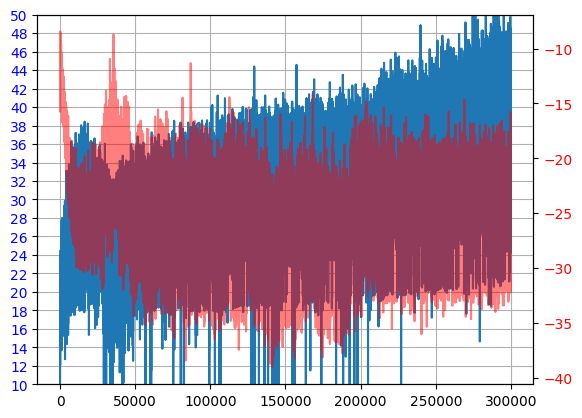

In [8]:
display(HTML(mb.main_bar.progress))
display(HTML(pb.progress))
fig, ax1 = plt.subplots()
ax1.plot(-10*np.array(losses)+6.02)
ax1.set_yticks(range(10,51,2))
ax1.set_ylim([10,50])
ax1.grid(True)
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(-10*np.array(rate_losses), color='red', alpha=0.5)
ax2.tick_params(axis='y', labelcolor='red')
plt.show()

In [9]:
torch.save({
    'config': config,
    'state_dict': model.state_dict()
}, '../../hf/autocodec/video_f8c48_lowres.pth')

In [ ]:
from IPython.display import display, clear_output
from ipywidgets import interact

model.train()

x = collate_fn(dataset['validation'].select([0]),config.epochs).to(device)

orig_dim = x.numel()

with torch.no_grad():
    z = model.encode(x)
    latent = model.quantize.compand(z).round()


latent_decoded = latent.clone()

with torch.no_grad():
    x_hat = model.decode(latent_decoded).clamp(-1, 1)

mse = torch.nn.functional.mse_loss(x, x_hat)
PSNR = -10 * mse.log10().item() + 6.02

print(f"PSNR: {PSNR:.2f} dB")

original_volume = x[0].cpu().numpy()
reconstructed_volume = x_hat[0].cpu().numpy()

def show_slices(slice_idx):
    clear_output(wait=True)
    orig_slice = to_pil_image(einops.rearrange(original_volume[:,slice_idx],'c h w -> h w c')/2+0.5)
    recon_slice = to_pil_image(einops.rearrange(reconstructed_volume[:,slice_idx],'c h w -> h w c')/2+0.5)
    display(orig_slice)
    display(recon_slice)

interact(show_slices, slice_idx=(0, original_volume.shape[1]-1, 1));

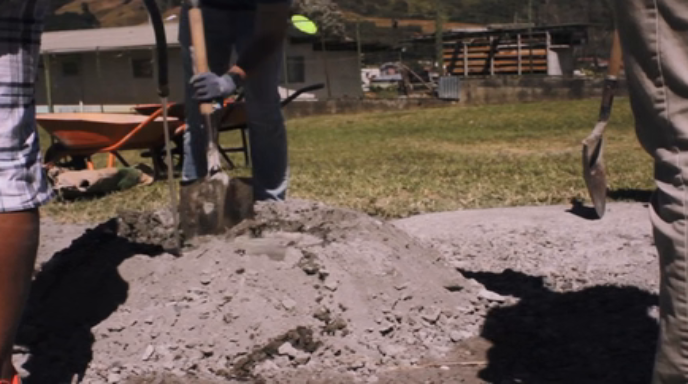

In [11]:
to_pil_image(einops.rearrange(original_volume[:,12],'c h w -> h w c')/2+0.5)

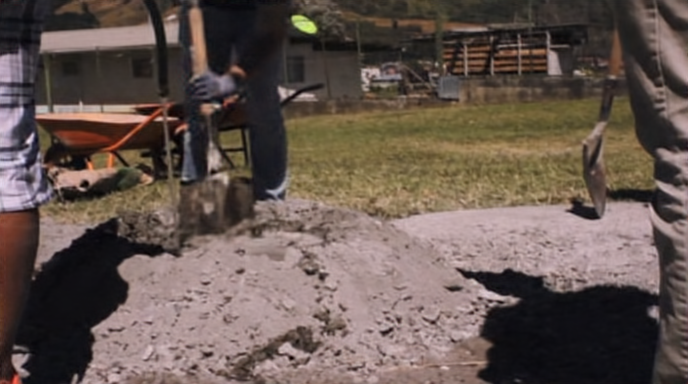

In [12]:
to_pil_image(einops.rearrange(reconstructed_volume[:,12],'c h w -> h w c')/2+0.5)